In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#!cd ./drive/'My Drive'/imm_face_db


In [3]:
import sys
sys.path = ['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/wloo/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/autoPyTorch-0.0.2-py3.6.egg', '/usr/lib/python3/dist-packages']
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from skimage import io
from skimage import data, color
from skimage.color import rgb2gray
from skimage.transform import rescale, resize, downscale_local_mean
import os
from os import path

## Part 1

In [4]:

i = 4 # person index
j = 1 # viewpoint index

def load_data(start=0,end=32,num_viewpoints=6):
    """
    returns dataset dict
    """
    dataset = []
    gender = 'm' # gender
    #root_dir = "./drive/My Drive/imm_face_db/"
    root_dir = "imm_face_db/"
    for i in range(start,end+1):
        for j in range(1,num_viewpoints+1):
            # load all facial keypoints/landmarks
            width = 640
            height=480
            path = root_dir + "{:02d}-{:d}{}".format(i,j,gender)
            if not os.path.exists(path+".asf"):
                new_gender = 'f'
                path = root_dir + "{:02d}-{:d}{}".format(i,j,new_gender)
            #print(path)
            file = open(path+".asf")
            img = io.imread(path+".jpg")
            #keypoints = get_keypoints(path, width, height)
            points = file.readlines()[16:74]
            landmark = []

            for point in points:
                x,y = point.split('\t')[2:4]
                landmark.append([float(x), float(y)])  

            # the nose keypoint
            nose_keypoint = np.array(landmark).astype('float32')[-6]

            gray = rgb2gray(img).astype(np.float32)
            gray = resize(gray, (60,80),anti_aliasing=True)

            dataset.append({"image":gray, "landmark":landmark, "nose_keypoint": nose_keypoint})
            
    print("done")
    return dataset
train =load_data(start=1,end=32)
test = load_data(start=33,end=40)

done
done


[[0.14084455 0.1477944  0.15255858 ... 0.14879401 0.14209335 0.1330916 ]
 [0.14316475 0.1510307  0.15670861 ... 0.15444842 0.1495579  0.1420511 ]
 [0.14718169 0.15352926 0.15976939 ... 0.1620047  0.15626289 0.14880696]
 ...
 [0.15259708 0.15741086 0.16229051 ... 0.22736184 0.21725182 0.20531291]
 [0.14595127 0.15234034 0.15794587 ... 0.21627837 0.20342757 0.18875588]
 [0.13868041 0.14431429 0.15007375 ... 0.20398432 0.19340877 0.1793866 ]]
58


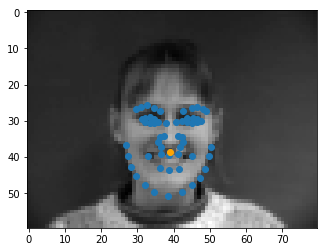

In [5]:
sample = train[43]
img = sample["image"]
landmark = sample["landmark"]
nose_keypoint = sample["nose_keypoint"]
gray = rgb2gray(img).astype(np.float32)
print(gray)
gray = resize(gray, (60,80),anti_aliasing=True)
implot = plt.imshow(gray, cmap=plt.cm.gray)
x = [i[0]*80 for i in landmark]
y = [i[1]*60 for i in landmark]
print(len(x))
plt.scatter(x,y)
plt.scatter([nose_keypoint[0]*80],[nose_keypoint[1]*60],c='orange')
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class NoseNet(nn.Module):

    def __init__(self):
        super(NoseNet, self).__init__()
        
        self.conv1 = nn.Conv2d(8, 16, 3)
        self.conv2 = nn.Conv2d(16, 20, 5)
        self.conv3 = nn.Conv2d(20, 18, 7)
        self.conv4 = nn.Conv2d(18, 16, 3)
        
        self.fc1 = nn.Linear(1, 120) 
        self.fc2 = nn.Linear(120, 2)
        #self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        
        x = F.max_pool2d(F.relu(self.conv4(x)), 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    

In [7]:
#dataloader
train_dataloader = DataLoader(train, batch_size=8,shuffle=True, num_workers=0)
test_dataloader = DataLoader(test, batch_size=8,shuffle=True, num_workers=0)

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"]="3,4,5"
import torch.optim as optim

#create net
net = NoseNet()
print(net)

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCHS = 25
criterion = nn.MSELoss()
train_losses = []
val_losses = []

# in your training loop:
for e in range(EPOCHS):
    epoch_train_loss = []
    epoch_test_loss = []
    for i_batch, sample_batched in enumerate(train_dataloader):
        input = sample_batched['image']
        input = input.unsqueeze(0).float()
        
        output = net(input)
        loss = criterion(output, sample_batched['nose_keypoint'])
        
        epoch_train_loss.append(loss.item())
        optimizer.step()    # Does the update
        optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
        
    for i_batch, sample_batched in enumerate(test_dataloader):
        test_input = sample_batched['image']
        test_input = test_input.unsqueeze(0).float()

        test_output = net(test_input)
        val_loss = criterion(test_output, sample_batched['nose_keypoint'])
        epoch_test_loss.append(val_loss.item())


    print("epoch: {}/{} train_loss: {} val_loss: {}".format(e+1,EPOCHS,np.mean(epoch_train_loss),np.mean(epoch_test_loss)))
    train_losses.append(np.mean(epoch_train_loss))
    val_losses.append(np.mean(epoch_test_loss))

NoseNet(
  (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(20, 18, kernel_size=(7, 7), stride=(1, 1))
  (conv4): Conv2d(18, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)
epoch: 1/25 train_loss: 0.29811793596794206 val_loss: 0.05708670554061731
epoch: 2/25 train_loss: 0.01618897434673272 val_loss: 0.006794388173148036
epoch: 3/25 train_loss: 0.0055230485935074585 val_loss: 0.0048261811801542836
epoch: 4/25 train_loss: 0.0038675263980015493 val_loss: 0.005460932928447922
epoch: 5/25 train_loss: 0.003753691431484185 val_loss: 0.005064913653768599
epoch: 6/25 train_loss: 0.0037751944376699007 val_loss: 0.004982498484120394
epoch: 7/25 train_loss: 0.0037868412861522907 val_loss: 0.005323342513293028
epoch: 8/25 train_loss: 0.003815123602786722 val_loss: 0.004946053610183299
epoch: 9/25 trai

Text(0,0.5,'loss')

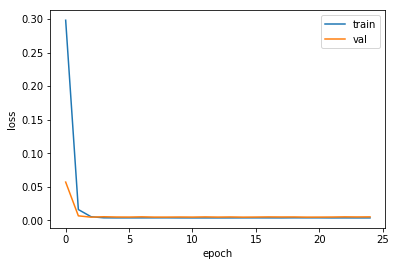

In [9]:
plt.plot(range(EPOCHS),train_losses)
plt.plot(range(EPOCHS),val_losses)
plt.legend(["train","val"])
plt.xlabel("epoch")
plt.ylabel("loss")

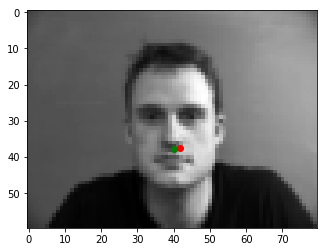

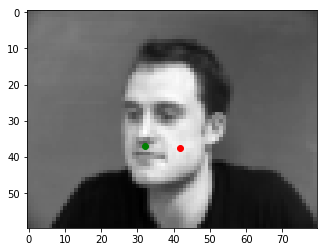

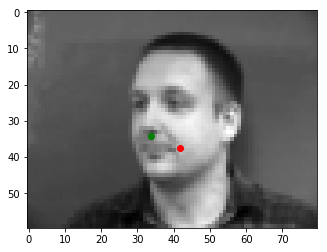

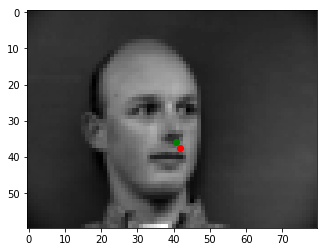

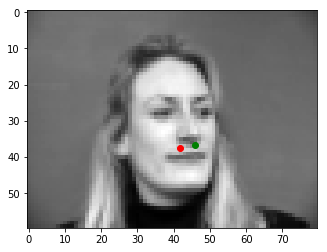

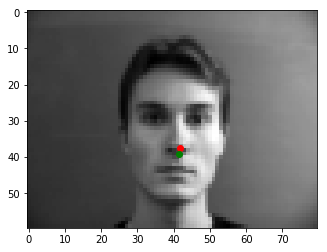

In [10]:
for i_batch, sample_batched in enumerate(test_dataloader):
    input = sample_batched['image']
    input_corr = input.unsqueeze(0).float()
    output = net(input_corr)
    
    plt.figure()
    plt.imshow(input[0].numpy(),cmap=plt.cm.gray)

    est=output.detach().numpy()[0][0][0]
    plt.scatter([est[0]*80],[est[1]*60],c='r')
    truth=sample_batched['nose_keypoint'][0].numpy()
    plt.scatter([truth[0]*80],[truth[1]*60],c='g')

    loss = criterion(output, sample_batched['nose_keypoint'])
    #print(loss)
    

## Part 2

In [11]:
def load_data_part_two(start=0,end=32,num_viewpoints=6):
    """
    returns dataset dict
    """
    dataset = []
    gender = 'm' # gender
    #root_dir = "./drive/My Drive/imm_face_db/"
    root_dir = "imm_face_db/"
    for i in range(start,end+1):
        for j in range(1,num_viewpoints+1):
            # load all facial keypoints/landmarks
            width = 640
            height=480
            path = root_dir + "{:02d}-{:d}{}".format(i,j,gender)
            if not os.path.exists(path+".asf"):
                new_gender = 'f'
                path = root_dir + "{:02d}-{:d}{}".format(i,j,new_gender)
            #print(path)
            file = open(path+".asf")
            img = io.imread(path+".jpg")
            #keypoints = get_keypoints(path, width, height)
            points = file.readlines()[16:74]
            landmark = []
            xs = []
            ys = []
            
            for point in points:
                x,y = point.split('\t')[2:4]
                landmark.extend([float(x), float(y)])
                xs.append(float(x)*240)
                ys.append(float(y)*180)
                
            gray = rgb2gray(img).astype(np.float32)
            gray = resize(gray, (180,240),anti_aliasing=False)
                
            x_t = np.random.randint(-15,15)
            y_t = np.random.randint(-15,15)

            xs = (np.asarray(xs)+x_t)
            ys = (np.asarray(ys)-y_t)
            
            xs = xs / 240
            ys = ys / 180
            
            shifted_landmark = []
            assert len(xs) == len(ys)
            for inddex in range(len(xs)):
                shifted_landmark.extend([xs[inddex],ys[inddex]])
                
            shifted_landmark = torch.FloatTensor(shifted_landmark)
            
            shifted_gray = np.roll(np.roll(gray,x_t,1),-y_t,0)
            
            dataset.append({"image":shifted_gray, "landmark":shifted_landmark})
            
            landmark = torch.FloatTensor(landmark)
            dataset.append({"image":gray, "landmark":landmark})
            
            if j==4 or j==3:
                #weighting procedure for odd angles
                for i in range(4):
                    dataset.append({"image":gray, "landmark":landmark})
            """
            elif j==6:
                #wildcard angles
                for i in range(5):
                    dataset.append({"image":gray, "landmark":landmark})
            """
         
    print('done.')
    return dataset

train_images =load_data_part_two(start=1,end=32)
test_images=load_data_part_two(start=33,end=40)

done.
done.


In [12]:
"""
from skimage import transform
class RandomRotate(object):
    def __init__(self,angle=15):
        self.angle=15

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmark']
        #ndimage.rotate(image, degree, reshape=False)
        radian_15 = self.angle
        rot = [[np.cos(radian_15),-np.sin(radian_15)],[np.sin(radian_15),np.cos(radian_15)]]
        
        rotated_landmarks = [np.asarray(rot).dot(p) for p in landmarks]
        rotated_image = transform.rotate(image, float(self.angle))
        
        return {'image': rotated_image, 'landmark': rotated_landmarks}
""";

In [13]:
"""
def rotate_data(im,angle,):
    input = data['image']


        plt.figure()
        im = rotate(input[0],10)
        plt.imshow(im,cmap=plt.cm.gray)
        
        truth_x = []
        truth_y = []
        truth=data['landmark'][0].numpy()
        for i in range(0,len(truth)-1,2):
            truth_x.append(truth[i]*240)
            truth_y.append(truth[i+1]*180)
            
        centroid = (sum(truth_x) / len(truth_x), sum(truth_y) / len(truth_y))
        
        truth_x = np.asarray(truth_x) - centroid[0]
        truth_y = np.asarray(truth_y) - centroid[1]
        
        radian_15 = np.pi/4#positive is ccw, negative is cw 
        rot = np.asarray([[np.cos(radian_15),-np.sin(radian_15)],[np.sin(radian_15),np.cos(radian_15)]])
        
        rotated = [rot.dot(t) for t in list(zip(truth_x,truth_y))]
        
        truth_x = [i[0] for i in rotated]
        truth_y = [i[1] for i in rotated]
        
        truth_x = truth_x+centroid[0]
        truth_y = truth_y+centroid[1]
""";

In [14]:
"""
from scipy.ndimage.interpolation import rotate


train_loader_two = DataLoader(train_images, batch_size=16, shuffle=True)

for i_batch, data in enumerate(train_loader_two):
    if i_batch == 0:
        input = data['image']
        plt.figure()
        width,height,_ = input.shape
        im = rotate(input[0],-0)
        
        plt.imshow(im,cmap=plt.cm.gray)
        
        truth_x = []
        truth_y = []
        truth=data['landmark'][0].numpy()
        for i in range(0,len(truth)-1,2):
            truth_x.append(truth[i]*240)
            truth_y.append(truth[i+1]*180)
            
        centroid = (sum(truth_x) / len(truth_x), sum(truth_y) / len(truth_y))
        
        #truth_x = np.asarray(truth_x) - (width/2)
        #truth_y = np.asarray(truth_y) - (height/2)
        
        radian_15 = 0.261799 #positive is ccw, negative is cw 
        rot = np.asarray([[np.cos(radian_15),-np.sin(radian_15)],[np.sin(radian_15),np.cos(radian_15)]])
        
        rotated = [rot.dot(t) for t in list(zip(truth_x,truth_y))]
        
        truth_x = truth_x#[i[0] for i in rotated]
        truth_y = truth_y#[i[1] for i in rotated]
        
        truth_x = np.asarray(truth_x) 
        truth_y = np.asarray(truth_y) 
        


        plt.scatter([truth_x],[truth_y],c='g')
""";

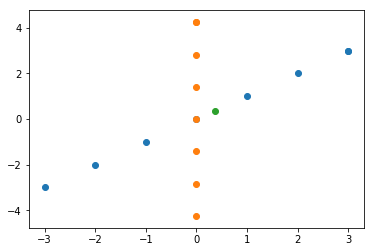

In [15]:
#rotation math
radian_15 = np.pi/4#positive is ccw, negative is cw 
rot = [[np.cos(radian_15),-np.sin(radian_15)],[np.sin(radian_15),np.cos(radian_15)]]
points = [[0,0],[-3,-3],[1,1],[2,2],[3,3],[-1,-1],[-2,-2],[3,3]]
x = [i[0] for i in points]
y = [i[1] for i in points]

rotated = []
for p in points:
    rotated.append(np.asarray(rot).dot(p))
    #rotated.append(np.asarray(p).dot(rot))

tx = [i[0] for i in rotated]
ty = [i[1] for i in rotated]
centroid = (sum(x) / len(x), sum(y) / len(y))

plt.scatter(x,y)
plt.scatter(tx,ty)
plt.scatter(centroid[0],centroid[1])

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(8, 12, 5)
        self.conv2 = nn.Conv2d(12, 20, 5)
        self.conv3 = nn.Conv2d(20, 36, 5)
        self.conv4 = nn.Conv2d(36, 16, 3)
        self.conv5 = nn.Conv2d(16, 8, 3)
        self.conv6 = nn.Conv2d(8, 120, 3)
        
        self.fc1 = nn.Linear(1, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 116)
        #self.fc3 = nn.Linear(84, 2)

        self.drop2 = nn.Dropout(0.0)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv5(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv6(x)), (2, 2))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [17]:
os.environ["CUDA_VISIBLE_DEVICES"]="3,4,5"
import torch.optim as optim

#create net
net = Net()
print(net)

# create your optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
EPOCHS = 30
criterion = nn.MSELoss()
losses = []
test_losses = []

train_loader_two = DataLoader(train_images, batch_size=8, shuffle=True)
test_dataloader_two = DataLoader(test_images, batch_size=8, shuffle=True)

# in your training loop:
for e in range(EPOCHS):
    epoch_loss = []
    epoch_test_loss = []
    for i_batch, sample_batched in enumerate(train_loader_two):
        input = sample_batched['image']

        input = input.unsqueeze(0).float()
        output = net(input)
        
        loss = criterion(output, sample_batched['landmark'])

        epoch_loss.append(loss.item())
        optimizer.step()    # Does the update
        optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
        if e == 20:
            optimizer.param_groups[0]['lr'] = 0.0001
            
    for i_batch, sample_batched in enumerate(test_dataloader_two):
        test_input = sample_batched['image']
        test_input = test_input.unsqueeze(0).float()

        test_output = net(test_input)
        val_loss = criterion(test_output, sample_batched['landmark'])
        epoch_test_loss.append(val_loss.item())

    print("epoch: {}/{} train_loss: {} test_loss: {}".format(e+1,EPOCHS,np.mean(epoch_loss),np.mean(epoch_test_loss)))
    losses.append(np.mean(epoch_loss))
    test_losses.append(np.mean(epoch_test_loss))
    
params = list(net.parameters())
#print(params[0])

Net(
  (conv1): Conv2d(8, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(20, 36, kernel_size=(5, 5), stride=(1, 1))
  (conv4): Conv2d(36, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(8, 120, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=116, bias=True)
  (drop2): Dropout(p=0.0)
)
epoch: 1/30 train_loss: 0.05234657113905996 test_loss: 0.006055589392781257
epoch: 2/30 train_loss: 0.004483186863944865 test_loss: 0.006100101803895086
epoch: 3/30 train_loss: 0.0045187785144662485 test_loss: 0.005949318059720099
epoch: 4/30 train_loss: 0.004599719024554361 test_loss: 0.006106578256003558
epoch: 5/30 train_loss: 0.004719326534541324 test_loss: 0.005933136329986155
epoch: 6/30 train_loss: 0.00498425958212465 test_loss: 0.006866591889411211
epoch: 7/30 train_lo

Text(0,0.5,'loss')

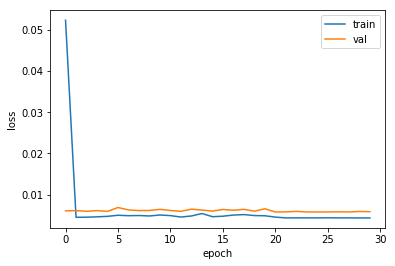

In [18]:
plt.plot(range(EPOCHS),losses)
plt.plot(range(EPOCHS),test_losses)
plt.legend(["train","val"])
plt.xlabel("epoch")
plt.ylabel("loss")

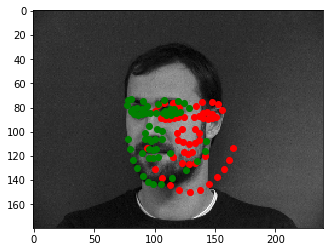

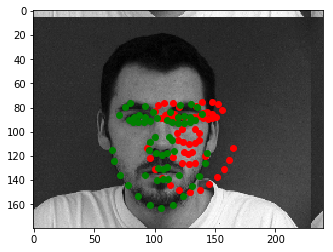

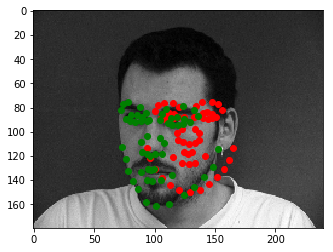

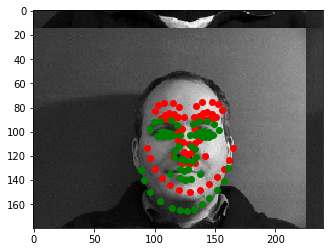

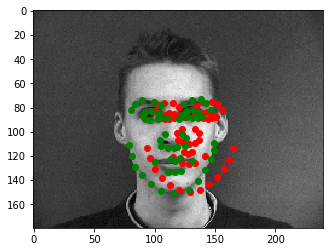

In [19]:
count=0
for i_batch, sample_batched in enumerate(train_loader_two):
    input = sample_batched['image']
    input_corr = input.unsqueeze(0).float()
    output = net(input_corr)
    est=output.detach().numpy()[0][0][0]
    est_paired_x = []
    est_paired_y = []
    for i in range(0,len(est)-1,2):
        est_paired_x.append(est[i]*240)
        est_paired_y.append(est[i+1]*180)
    

    
    truth_x = []
    truth_y = []
    truth=sample_batched['landmark'][0].numpy()
    for i in range(0,len(truth)-1,2):
        truth_x.append(truth[i]*240)
        truth_y.append(truth[i+1]*180)
    
    if count < 5:
        plt.figure()
        plt.imshow(input[0].numpy(),cmap=plt.cm.gray)
        plt.scatter(est_paired_x,est_paired_y,c='r')
        plt.scatter([truth_x],[truth_y],c='g')
        count+=1
    #loss = criterion(output, sample_batched['landmark'])
    #print(loss)
    

In [20]:
#https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=6BYCjgBYwyAQ
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.detach().numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].detach().numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

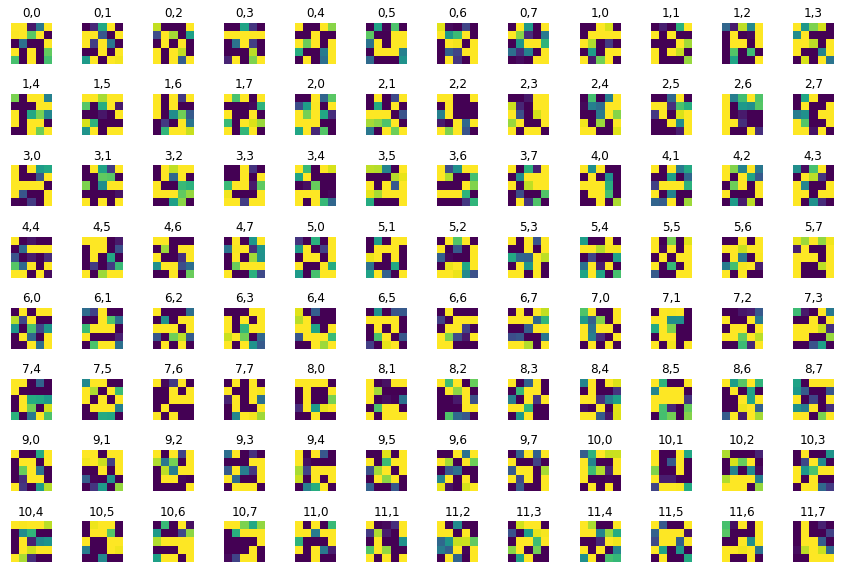

In [21]:
#visualize weights for alexnet - first conv layer
params = list(net.parameters())
plot_filters_single_channel(params[0])

In [22]:
#second one is so big it is unsavable
#plot_filters_single_channel(params[2])

# Part 3 

In [23]:
"""
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'
"""

"\nif not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):\n    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip\n    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    \n    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'\n"

In [24]:
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
    img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
    box = filename[0].attrib
    # x, y for the top left corner of the box, w, h for box width and height
    bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

    landmark = []
    for num in range(68):
        x_coordinate = int(filename[0][num].attrib['x'])
        y_coordinate = int(filename[0][num].attrib['y'])
        landmark.append([x_coordinate, y_coordinate])
    landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

[ 67. -57. 373. 414.]
[ 67.    0.  426.  517.5]


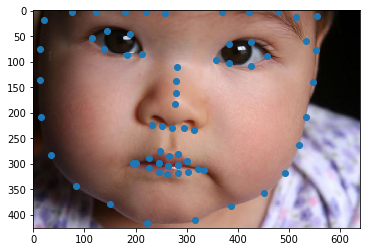

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

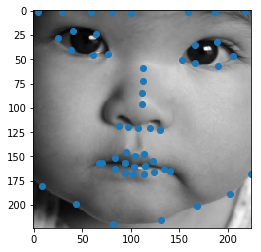

In [25]:
#from skimage import util
i=56
x = [item[0] for item in landmarks[i]]
y = [item[1] for item in landmarks[i]]
#im2=Image.open(img_filenames[i])
im = io.imread(img_filenames[i])
height,width,_ = im.shape
plt.figure()
plt.scatter(x,y) 
plt.imshow(im)

bbox = bboxes[i]
#do scaling
factor = 1.25
print(bbox)
bbox[0] = max(0,bbox[0])
bbox[1] = max(0,bbox[1])
bbox[2] = min(height,bbox[2]*factor)
bbox[3] = min(width,bbox[3]*factor)
print(bbox)
bbox_in=[bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]]
x = [item[0]-max(0,bbox[0]) for item in landmarks[i]]
y = [item[1]-max(0,bbox[1]) for item in landmarks[i]]
#im2=im2.crop(bbox_in)
im = rgb2gray(im).astype(np.float32) / 255 - 0.5
plt.figure()
#plt.imshow(im,cmap=plt.cm.gray) 
im = im[max(0,int(bbox[1])):int(bbox[1]+bbox[3]),max(int(bbox[0]),0):int(bbox[0]+bbox[2])]
plt.figure()
#plt.imshow(im,cmap=plt.cm.gray) 
scale = 224/im.shape[0]
scale_matrix = np.asarray([[scale,0],[0,scale]])
scaled_pts = [scale_matrix.dot(t) for t in list(zip(x,y))]
scaled_x = [item[0] for item in scaled_pts]
scaled_y = np.asarray([item[1] for item in scaled_pts])

im = resize(im, (224,224),anti_aliasing=True)
plt.figure()
plt.scatter(scaled_x,scaled_y)
plt.imshow(im,cmap=plt.cm.gray)    
        

In [ ]:
def load_big_data(start_index, end_index):
    dataset = []
    for i in range(start_index, end_index):
        scaled_pts = []
        
        im = io.imread(img_filenames[i])
        bbox = bboxes[i]
        landmark=landmarks[i]
        
        """
        factor = 1.25
        bbox[0] = max(0,bbox[0])
        bbox[1] = max(0,bbox[1])
        bbox[2] = min(height,bbox[2]*factor)
        bbox[3] = min(width,bbox[3]*factor)
        """
        
        #im = rgb2gray(im).astype(np.float32) / 255 - 0.5 #grey
        im = rgb2gray(im).astype(np.float32)#grey
        
        #cropping
        x = [item[0]-max(0,bbox[0]) for item in landmarks[i]]
        y = [item[1]-max(0,bbox[1]) for item in landmarks[i]]
        im = im[max(0,int(bbox[1])):int(bbox[1]+bbox[3]),max(int(bbox[0]),0):int(bbox[0]+bbox[2])]
        
        """
        x_t = np.random.randint(-15,15)
        y_t = np.random.randint(-15,15)

        xs = (np.asarray(xs)+x_t)
        ys = (np.asarray(ys)-y_t)
        

        xs = xs / 240
        ys = ys / 180

        shifted_landmark = []
        assert len(xs) == len(ys)
        for inddex in range(len(xs)):
            shifted_landmark.extend([xs[inddex],ys[inddex]])

        shifted_landmark = torch.FloatTensor(shifted_landmark)

        shifted_gray = np.roll(np.roll(im,x_t,1),-y_t,0)

        dataset.append({"image":shifted_gray, "landmark":shifted_landmark})
        """
        
        

        #scaling
        scale = 224/im.shape[0]
        scale_matrix = np.asarray([[scale,0],[0,scale]])
        for t in list(zip(x,y)):
            scaled_pts.extend(scale_matrix.dot(t) / 224)
        scaled_pts = torch.FloatTensor(scaled_pts)
            
        im = resize(im, (224,224),anti_aliasing=False)
        
        assert len(scaled_pts) == 136
        
        dataset.append({"image":im,"landmark":scaled_pts, "scale":scale, "bbox":bbox})
    print("done.")
    return dataset

ibug_data_train = load_big_data(0,4620)
ibug_data_test = load_big_data(4620,6666)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]="4,5"
import torch.optim as optim
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)

#adjust net outputs
resnet18.conv1 = nn.Conv2d(6, 64, 7, 2,3,bias=False)
resnet18.fc = nn.Linear(in_features=512, out_features=816, bias=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using {}.".format(device))

# create your optimizer
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
EPOCHS = 20
criterion = nn.MSELoss()
#criterion = nn.L1Loss()
losses = []
test_losses = []

train_loader_three = DataLoader(ibug_data_train, batch_size=6, shuffle=True)
test_loader_three = DataLoader(ibug_data_test, batch_size=6, shuffle=True)

# in your training loop:
for e in range(EPOCHS):
    epoch_loss = []
    epoch_test_loss = []
    for i_batch, sample_batched in enumerate(train_loader_three):
        input = sample_batched['image']
        input = input.unsqueeze(0).float()
        output = resnet18(input)
        
        gt = sample_batched['landmark']
        compare = []
        for i in range(len(gt)):
            compare.extend(gt[i].tolist())
        assert(len(compare)==816)
        gt_compare = torch.FloatTensor(compare)
        
        loss = criterion(output, gt_compare) #WARNING THIS IS BROKEN

        epoch_loss.append(loss.item())
        optimizer.step()    # Does the update
        optimizer.zero_grad()   # zero the gradient buffers
        loss.backward()
        if e == 10:
            optimizer.param_groups[0]['lr'] = 0.0001
            
    for i_batch, sample_batched_t in enumerate(test_loader_three):
        test_input = sample_batched_t['image']
        test_input = test_input.unsqueeze(0).float()

        test_output = resnet18(test_input)
        
        test_gt = sample_batched_t['landmark']
        compare_t = []
        for i_t in range(len(test_gt)):
            compare_t.extend(test_gt[i_t].tolist())
        assert(len(compare_t)==816)
        gt_compare_t = torch.FloatTensor(compare_t)
        
        val_loss = criterion(test_output, gt_compare_t)
        epoch_test_loss.append(val_loss.item())
            
        
    print("epoch: {}/{} train_loss: {} test_loss: {}".format(e+1,EPOCHS,np.mean(epoch_loss),np.mean(epoch_test_loss)))
    losses.append(np.mean(epoch_loss))
    test_losses.append(np.mean(epoch_test_loss))


In [ ]:
plt.plot(range(EPOCHS),losses)
plt.xlim(0,20,1)
plt.plot(range(EPOCHS),test_losses)
plt.legend(["train","val"])
plt.xlabel("epoch")
plt.ylabel("loss")

In [ ]:
#Validate Results
count=0
for i_batch, sample_batched in enumerate(train_loader_three):
    if count > 5:
        break
    input_img = sample_batched['image']
    input_corr = input_img.unsqueeze(0).float()
    output = resnet18(input_corr)
    est=output.detach().numpy()[0]

    for b in range(len(input_img)):
        est_paired_x = []
        est_paired_y = []
        start = (136*b)
        end = start+136
        for i in range(start,end-1,2):
            est_paired_x.append(est[i]*224)
            est_paired_y.append(est[i+1]*224)

        truth_x = []
        truth_y = []
        truth=sample_batched['landmark'][b].numpy()
        for i in range(0,135,2):
            truth_x.append(truth[i]*224)
            truth_y.append(truth[i+1]*224)

        if count < 3:
            plt.figure()
            plt.imshow(input_img.numpy()[b],cmap=plt.cm.gray)
            #plt.scatter(est_paired_x,est_paired_y,c='r')
            plt.scatter([truth_x],[truth_y],c='g')
            count+=1
    

## Kaggle Submission

In [ ]:
#!wget https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/labels_ibug_300W_test_parsed.xml

In [ ]:
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('labels_ibug_300W_test_parsed.xml')
root = tree.getroot()

kaggle_bboxes = []
kaggle_img_filenames = []
root_dir = 'ibug_300W_large_face_landmark_dataset'
for filename in root[2]:
    kaggle_img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
    box = filename[0].attrib
    kaggle_bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

kaggle_bboxes = np.array(kaggle_bboxes).astype('float32')
#kaggle_img_filenames, kaggle_bboxes

In [ ]:
kaggle_dataset = []
for i in range(len(kaggle_img_filenames)):
    scaled_pts = []
    im = io.imread(kaggle_img_filenames[i])
    bbox = kaggle_bboxes[i]

    #im = rgb2gray(im).astype(np.float32) / 255 - 0.5 #grey
    im = rgb2gray(im).astype(np.float32)

    #cropping
    im = im[max(0,int(bbox[1])):int(bbox[1]+bbox[3]),max(int(bbox[0]),0):int(bbox[0]+bbox[2])]
    
    #resize 
    im = resize(im, (224,224),anti_aliasing=True)

    kaggle_dataset.append({"image":im, "bbox":bbox, "idx":i})
print(len(kaggle_dataset))

In [ ]:
kaggle_loader = DataLoader(kaggle_dataset, batch_size=6, shuffle=True)
print(len(kaggle_dataset))

In [ ]:
count=0
tot=0
IMG_LIM = 3
f = open("output.csv", "w")
f.write("Id,Predicted\n")
id = 0
final = []
for i_batch, sample_batched in enumerate(kaggle_loader):
    if IMG_LIM > 0 and count >= IMG_LIM:
        break
    input_img = sample_batched['image']
    orig_indices = sample_batched['idx']
    input_corr = input_img.unsqueeze(0).float()
    output = resnet18(input_corr) #batch of 6
    
    for b in range(6):
        im = io.imread(kaggle_img_filenames[orig_indices[b]])
        bbox = kaggle_bboxes[orig_indices[b]]

        est=output.detach().numpy()[0]
        est_paired_x = []
        est_paired_y = []

        start = (136*b)
        end = start+136
        for i in range(start,end-1,2):
            est_paired_x.append(est[i]*224)
            est_paired_y.append(est[i+1]*224)
            
            
        shift_x = min(est_paired_x)
        shift_y = min(est_paired_y)
        
        est_paired_x = np.asarray(est_paired_x) - shift_x
        est_paired_y = np.asarray(est_paired_y) - shift_y   
        
        scale = float(bbox[2]/224)
        
        transform = np.asarray([[scale,0],[0,scale]])
        scaled = [transform.dot(tup) for tup in list(zip(est_paired_x,est_paired_y))]
        
        x = [item[0]+bbox[0] for item in scaled]
        y = [item[1]+bbox[1] for item in scaled]
        assert len(x)==len(y)
        tot+=len(x)
        tot+=len(y)
        
        for i in range(len(x)):
            #label_x = "image_{:03d}_keypoints_{:02d}_x".format(orig_indices[b]+1,i+1)
            #label_y = "image_{:03d}_keypoints_{:02d}_y".format(orig_indices[b]+1,i+1)
            #f.write("{},{}\n{},{}\n".format(id,int(x[i]),id+1,int(y[i])))
            final.append([int(id),int(x[i])])
            final.append([int(id+1),int(y[i])])
            #f.write("{},{}\n".format(id+1,int(y[i])))
            id+=2
        
        
        if IMG_LIM > 0 and count < IMG_LIM:
            print(bbox)
            plt.figure()
            plt.imshow(im)
            #plt.imshow(input_img.numpy()[b],cmap=plt.cm.gray)
            plt.scatter(x,y,c='r')
            count+=1
        
np.savetxt("output.csv",np.asarray(final),delimiter=',',header="Id,Predicted",fmt='%d')
print(tot)

## Test Images


In [ ]:
derek = io.imread("DerekPicture.jpg")
george = io.imread("george_small.jpg")
will_danish = io.imread("will_danish.jpg")
will2 = io.imread("will2.jpg")
epilogue_dataset = []
epilogue_bboxes = []
epilogue_filenames = ["DerekPicture.jpg","george_small.jpg","will_danish.jpg","will2.jpg","will2.jpg","will2.jpg"]

In [ ]:
bbox = [200,200,400,400]
epilogue_bboxes.append(bbox)
derek_cropped = derek[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]
derek_cropped = resize(derek_cropped, (224,224),anti_aliasing=False)
derek_cropped = rgb2gray(derek_cropped).astype(np.float32)#grey
epilogue_dataset.append({"image":derek_cropped, "bbox":bbox, "idx":0})
#plt.imshow(derek_cropped)

bbox = [250,100,400,400]
epilogue_bboxes.append(bbox)
george_cropped = george[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]
george_cropped = resize(george_cropped, (224,224),anti_aliasing=False)
george_cropped = rgb2gray(george_cropped).astype(np.float32)#grey
epilogue_dataset.append({"image":george_cropped, "bbox":bbox, "idx":1})

bbox = [180,180,270,270]
epilogue_bboxes.append(bbox)
will_danish_cropped = will_danish[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]
will_danish_cropped = resize(will_danish_cropped, (224,224),anti_aliasing=False)
will_danish_cropped = rgb2gray(will_danish_cropped).astype(np.float32)#grey
epilogue_dataset.append({"image":will_danish_cropped, "bbox":bbox, "idx":2})

bbox = [100,300,250,250]
epilogue_bboxes.append(bbox)
will2_cropped = will2[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]
will2_cropped = resize(will2_cropped, (224,224),anti_aliasing=False)
will2_cropped = rgb2gray(will2_cropped).astype(np.float32)#grey
epilogue_dataset.append({"image":will2_cropped, "bbox":bbox, "idx":3})

bbox = [100,300,250,250]
epilogue_bboxes.append(bbox)
will2_cropped = will2[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]
will2_cropped = resize(will2_cropped, (224,224),anti_aliasing=False)
will2_cropped = rgb2gray(will2_cropped).astype(np.float32)#grey
epilogue_dataset.append({"image":will2_cropped, "bbox":bbox, "idx":4})

bbox = [100,300,250,250]
epilogue_bboxes.append(bbox)
will2_cropped = will2[bbox[0]:bbox[0]+bbox[2],bbox[1]:bbox[1]+bbox[3]]
will2_cropped = resize(will2_cropped, (224,224),anti_aliasing=False)
will2_cropped = rgb2gray(will2_cropped).astype(np.float32)#grey
epilogue_dataset.append({"image":will2_cropped, "bbox":bbox, "idx":5})


In [ ]:
epilogue_loader = DataLoader(epilogue_dataset, batch_size=6, shuffle=True)

In [ ]:
for i_batch, sample_batched in enumerate(epilogue_loader):
    input_img = sample_batched['image']
    orig_indices = sample_batched['idx']
    input_corr = input_img.unsqueeze(0).float()
    output = resnet18(input_corr) #batch of 6
    
    for b in range(6):
        im = io.imread(epilogue_filenames[orig_indices[b]])
        bbox = epilogue_bboxes[orig_indices[b]]

        est=output.detach().numpy()[0]
        est_paired_x = []
        est_paired_y = []

        start = (136*b)
        end = start+136
        for i in range(start,end-1,2):
            est_paired_x.append(est[i]*224)
            est_paired_y.append(est[i+1]*224)
            
            
        shift_x = min(est_paired_x)
        shift_y = min(est_paired_y)
        
        est_paired_x = np.asarray(est_paired_x) - shift_x
        est_paired_y = np.asarray(est_paired_y) - shift_y   
        
        scale = float(bbox[2]/224)
        
        transform = np.asarray([[scale,0],[0,scale]])
        scaled = [transform.dot(tup) for tup in list(zip(est_paired_x,est_paired_y))]
        
        x = [item[0]+bbox[0] for item in scaled]
        y = [item[1]+bbox[1] for item in scaled]
        assert len(x)==len(y)
        tot+=len(x)
        tot+=len(y)
        
        print(bbox)
        plt.figure()
        plt.imshow(im)
        #plt.imshow(input_img.numpy()[b],cmap=plt.cm.gray)
        plt.scatter(x,y,c='r')
        count+=1